#### Import the DCLProject API and connect to the local UCI HAR project file

In [72]:
from sensiml.dclproj import DCLProject

ds = DCLProject(path=r"../../UCI HAR/UCI HAR.dsproj")

#### Get all the segments that are int he session **"Label Session"**

This will return a **DataSegments** object containing all of the **DataSegments** the specified session. The **DataSegments** object holds **DataSegment** objects which have information about the metadata for each segment along with the data. The **DataSegments** object also has helper functions for visualization and conversion

C:\\Users\\Christopher Knorowsk\\Software\\sml_server\\sensiml\sensiml\dclproj\dclproj.py:232: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  capture_metadata = self._list_captures_metadata().to_dict(orient="rows")


<AxesSubplot:>

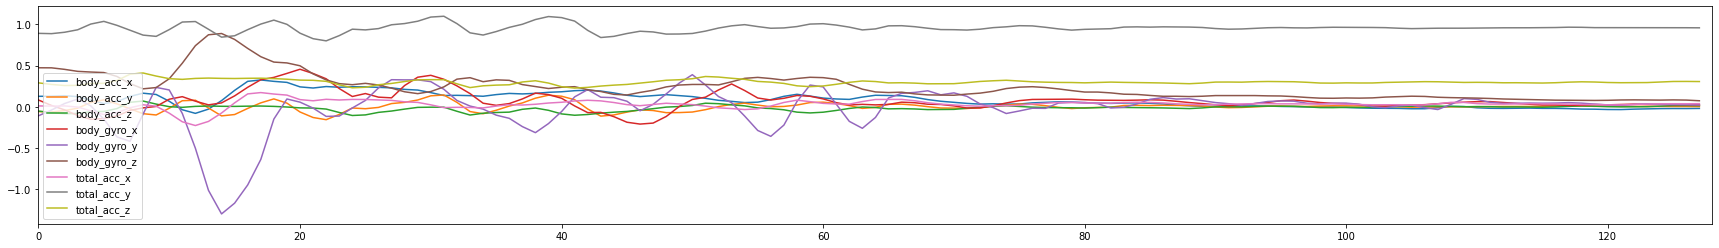

In [73]:
segments = ds.get_segments("Label Session")
segments[0].plot()

#### Filter out only the DataSegments that have metadata Set==Train and then convert that to a timeseries, which is the format that tsfresh expects

In [74]:
train_segments = segments.filter_by_metadata({"Set":["Train"]})
timeseries, y = train_segments.to_timeseries()

#### Import tsfresh for feature extraction and sklearn for  model training

In [ ]:
from tsfresh import select_features, extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

#### Generate all features for subset of dataset

We are going to use tsfresh **extract_features** method to generate lots of features from each DataSegment. To save processing time, we will only generate features on a subset of the data to begin with. 

In [57]:
timeseries, y = train_segments.to_timeseries()
X = extract_features(timeseries[timeseries["id"]<1000], column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


#### Split the dataset into train and test so we can validate the hyperparameters we select

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y[y['id']<1000].label_value, test_size=.2)

#### Apply feature selection to get a subset of features

Using the **select_feature** API from tsfresh, we filter out features that are not significant to the model. You can read the tsfresh documentation for more information.

In [70]:
X_train_filtered_multi = select_features(X_train.reset_index(drop=True), y_train.reset_index(drop=True), multiclass=True, n_significant=5)
X_train_filtered_multi = X_train_filtered_multi.filter(sorted(X_train_filtered_multi.columns))


### Do a grid search to find the lowest number of relevant features that gives good performance

We filter the number of features down even more by computing the relevance table of the filtered features. We then do a search for the lowest number of features that provides a good model. Since computing features can be CPU intensive and too many features makes it easier for the model to overfit, we try to reduce the number of features without affecting performance.

In [ ]:

def get_top_features(relevance_table, number):
    return sorted(relevance_table["feature"][:number])

relevance_table = calculate_relevance_table(X_train_filtered_multi, y_train.reset_index(drop=True))
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)

for i in range(20,400,20):    
    relevant_features = get_top_features(relevance_table, i)
    X_train_relevant_features = X_train[relevant_features]
    classifier_selected_multi = RandomForestClassifier()
    classifier_selected_multi.fit(X_train_relevant_features, y_train)
    X_test_filtered_multi = X_test[X_train_relevant_features.columns]
    print(i, f1_score(y_test, classifier_selected_multi.predict(X_test_filtered_multi), average="weighted"))

#### After doing the search, we select **120** as the number of features to use

In [64]:
relevant_features = get_top_features(relevance_table, 120 )
X_train_relevant_features = X_train[relevant_features]

#### Generate only relevant features and train the final Model

Using the tsfresh kind_to_fc_parameters parameter, we can only generate the features that are relevant. Now, we generate those features from  the entire training dataset and use that to train our model. 

In [65]:
from tsfresh.feature_extraction.settings import from_columns

kind_to_fc_parameters = from_columns(X_train_relevant_features)

timeseries, y = segments.to_timeseries()
X = extract_features(timeseries, column_id="id", column_sort="time",kind_to_fc_parameters=kind_to_fc_parameters)
X_train, X_test, y_train, y_test = train_test_split(X, y.label_value, test_size=.2)

classifier_selected_multi = RandomForestClassifier()
classifier_selected_multi.fit(X_train, y_train)
print(classification_report(y_test, classifier_selected_multi.predict(X_test)))
ConfusionMatrixDisplay(confusion_matrix(y_test, classifier_selected_multi.predict(X_test))).plot()

Feature Extraction: 100%|██████████| 30/30 [02:09<00:00,  4.32s/it]


#### Save the model and feature pipeline for inference in the Data Studio

Now that we have a trained model and feature extraction pipeline, we dump the model into a pickle file and dump the kind_to_fc_parameters into a json. We will use those in the Data Studio to load the model and extract the features there. 

In [71]:
import pickle
import json

with open('model.pkl', 'wb') as out:
    pickle.dump(classifier_selected_multi, out)
    
json.dump(kind_to_fc_parameters, open("fc_params.json",'w'))